In [4]:
import Pkg;
#Pkg.add("CSV")
#Pkg.add("DataFrames")
#Pkg.add("Random")
#Pkg.add("StatsBase")
#Pkg.add("Statistics")
#Pkg.add("Zygote")
#Pkg.add("LinearAlgebra")
#Pkg.add("Plots")
#Pkg.add("CategoricalArrays")
#Pkg.add("XLSX")
#


using CSV
using DataFrames
using Pkg
using Random
using StatsBase
using Statistics
using LinearAlgebra
using Zygote
using Plots 
using CategoricalArrays
using ExcelFiles
using DataFrames
using XLSX
using MAT
include("common.jl")
using Pkg
using SavitzkyGolay
using Dates
using StatsBase, Random

Initializing the parameters:
- sp - value between [0.1 - 0.9] representing the percentage of randomly selected samples in each Kernel Flows operation
- dim - integer between [1 - H ]number of Latent Variables in Kernel PLS. The maximum is equal to the maximum number of samples in the sub-batch.
- nsamp - number of sub-samplings in each iteration
- initialParams - initial Kernel parameters. They can be positive, or negative, as the algorithm considers exp(params). The number of initial parameters is dependent on the kernel type. If a kernel function with one scaling parameter is utilized (e.g. "gaussian" kernel), the number of parameters is two (i.e [1 1]), as a regularization parameter is always included. If the kernel version is "individual", the algorithm initializes the values with 0. If the kernel version is "withPCA", the number of initial values is noPCs + 1. 
- iter - the number of Kernel Flows iterations
- learnRate - the learning rate, one value between [0.00001 - 0.9] 
- kernelType - "gaussian", "cauchy", "matern1/3", "matern3/2", "matern5/2"
- kernelVersion - "combined" (takes all the variables at once; only requires two initial parameters); "individual" (fits a kernel parameter for each of the original variable values); "individualScaled" (fits two kernel parameters for each of the original variable values: a width and a scale); "withPCA" (fits a kernel parameter for each PC); "family" (forms a family of summed kernels; the initialParams needs to be a vector with 11 values)
- dataset - now available in the file there is "ConcreteStrength" - add a function with your dataset
- noPCs - if you select the kernelVersion "withPCA", add the number of PCs
- PLS - available there are: "RBF", "NIPALS" and "SIMPLS". For univariate responses, "SIMPLS" is the most efficient. 

In [9]:
model = Dict(:testSize => 0.2, 
    :sp     => 0.5, 
    :dim    => 4, 
    :nsamp  => 10, 
    :initialParams => ones(2), 
    :iter   => 3000, 
    :learnRate => 0.1, 
    :kernelType => "matern5/2", 
    :kernelVersion => "combined", 
    :dataset    => "ConcreteStrength",
    :noPCs      => 20,
    :PLS        => "SIMPLS")

model = loadData(model)

Dict{Symbol, Any} with 22 entries:
  :stdX          => [104.061 86.531 … 80.0312 61.9348]
  :Xtest         => [-1.14726 1.32634 … -0.790222 -0.277657; 0.0923873 -0.84629…
  :stdY          => [16.865;;]
  :sp            => 0.5
  :testSize      => 0.2
  :dataset       => "ConcreteStrength"
  :initialParams => [1.0, 1.0]
  :X             => [-0.477468 -0.846293 … -0.195453 -0.277657; 1.82213 0.50813…
  :nsamp         => 10
  :kernelVersion => "combined"
  :noPCs         => 20
  :x             => [540.0 0.0 … 676.0 28.0; 540.0 0.0 … 676.0 28.0; … ; 159.1 …
  :muX           => [279.386 73.2306 … 773.242 45.1966]
  :dim           => 4
  :Y             => [-0.663324; 1.13686; … ; 2.58957; -0.614109;;]
  :iter          => 3000
  :Ytest         => [-0.171179; -1.25271; … ; -0.656209; 1.7298;;]
  :y             => [79.99, 61.89, 40.27, 41.05, 44.3, 47.03, 43.7, 36.45, 45.8…
  :kernelType    => "matern5/2"
  ⋮              => ⋮

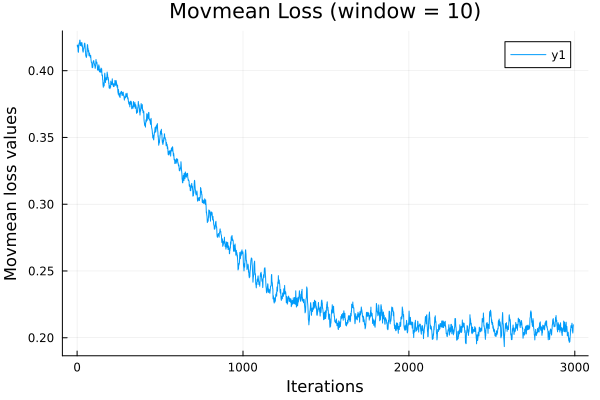

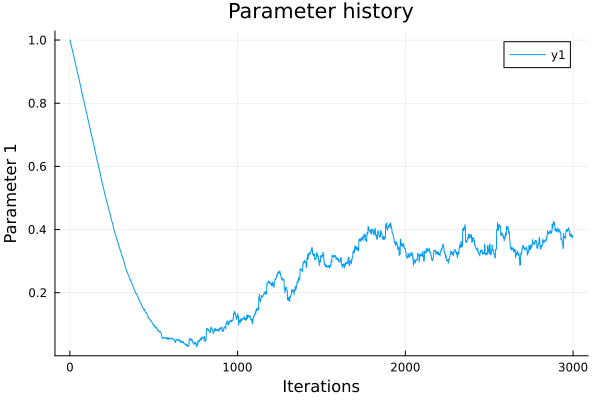

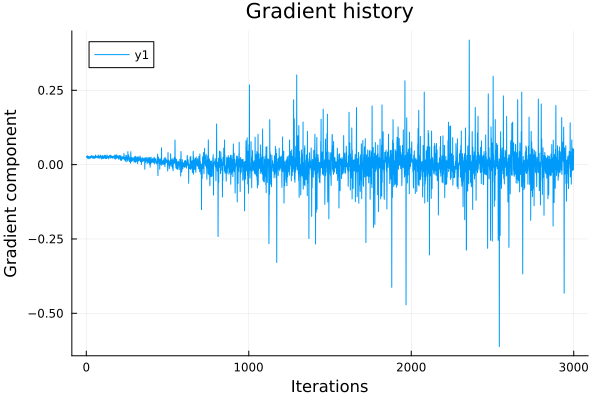

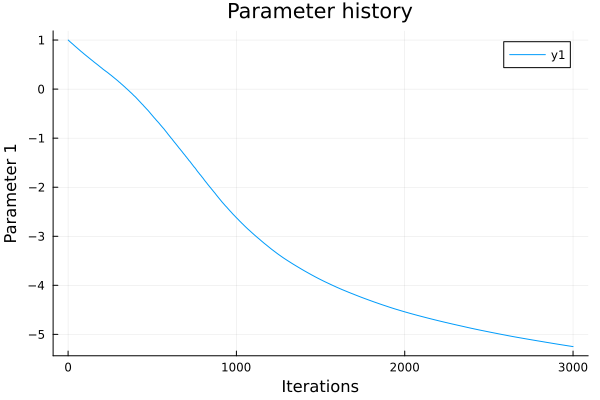

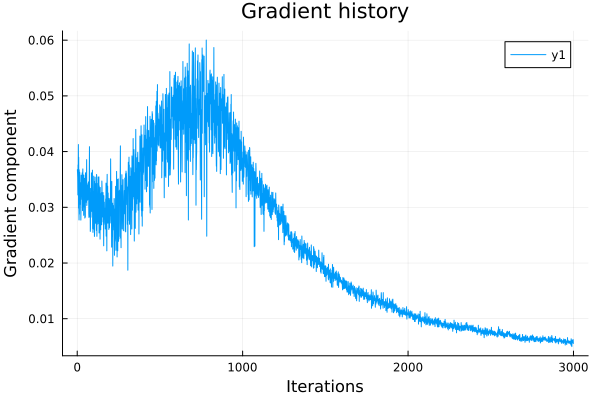

In [10]:
model, parameterHistory, lossHistory, gradHistory = optimize_parameters(model)

plt = plot(model[:runningLoss])
plot!(title = "Movmean Loss (window = 10)", xlabel = "Iterations", ylabel = "Movmean loss values")
display(plt)


for i = 1:model[:np]
    plt = plot(parameterHistory[:,i])
    plot!(title = "Parameter history", xlabel = "Iterations", ylabel = "Parameter 1")#    display(plt)
    display(plt)

    plt = plot(gradHistory[2:end,i])
    plot!(title = "Gradient history", xlabel = "Iterations", ylabel = "Gradient component")
    display(plt)
end

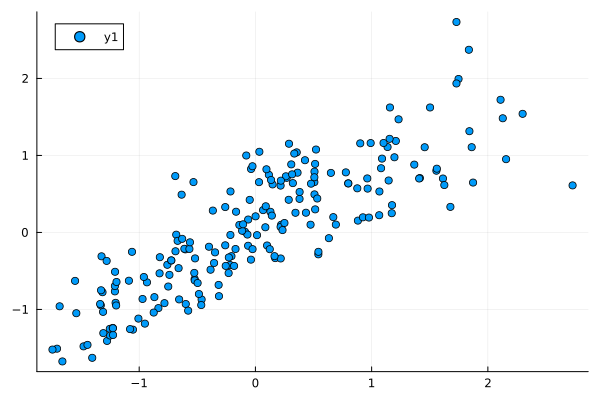

10.789384440163012

In [11]:
model = predict_KF(model)

#test = mean(eachrow(model[:X]))' * ones(8,1)

plt = plot(scatter(reshape(model[:Ytest], :, 1), reshape(model[:YPred], :, 1)))
display(plt)

RSS = sum((model[:YPred] .- model[:Ytest]).^2)
TSS = sum((model[:Ytest] .- mean(model[:Ytest])).^2)
#println(RSS)
#println(TSS)
R2 = 1 - RSS/TSS

TSSC = sum((model[:Y] .- mean(model[:Y])).^2)
Q2 = 1 - RSS/TSSC

function rmse(y_pred, y_true)
    return sqrt(mean((y_pred .- y_true).^2))
end

NRMSE = (rmse(model[:YPred], model[:Ytest])/ (maximum(model[:Y]) - minimum(model[:Y]))) * 100

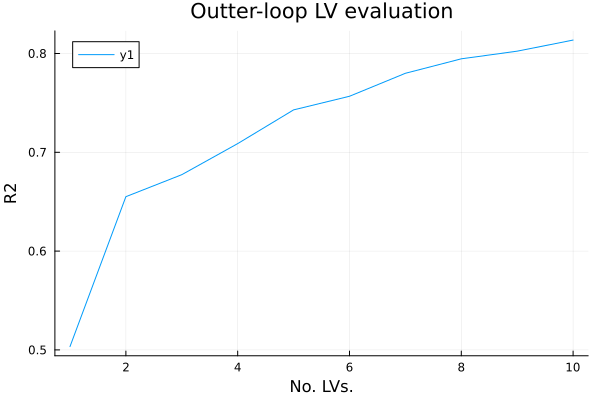

[0.5033343042926691; 0.6550786882061057; 0.6773433387451107; 0.7087820963539964; 0.7429188553018375; 0.7567037786447967; 0.7799564672403203; 0.7945988152574919; 0.8023455119348657; 0.8135720693377805;;]


In [12]:
R22 = zeros(10,1)
Q2NIPALS = zeros(10,1)
NRMSENIPALS = zeros(10,1)


function rmse(y_pred, y_true)
    return sqrt(mean((y_pred .- y_true).^2))
end

for i = 1:10
    model[:dim] = i
    model = predict_KF(model)

    RSS = sum((reshape(model[:YPred], :, 1) .- reshape(model[:Ytest],:,1)).^2)
    TSS = sum((model[:Ytest] .- mean(model[:Ytest])).^2)

    TSSC = sum((model[:Y] .- mean(model[:Y])).^2)

    R22[i] = 1.0 - RSS/TSS
    Q2NIPALS[i] = 1.0 - RSS/TSSC
    NRMSENIPALS[i] = ((rmse(model[:YPred], model[:Ytest])/ (maximum(model[:Y]) - minimum(model[:Y])))) * 100
end


plt = plot(R22)
xlabel!("No. LVs.")
ylabel!("R2")
title!("Outter-loop LV evaluation")
display(plt)

println(R22)